**<h1>INSTALL NECESSARY LIBRARIES</h1>**

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [2]:
pip install tf-keras

In [3]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h1>IMPORT LIBRARIES</h1>**

In [5]:
import re
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)
data

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

**<h1>SPLIT DATASET</h1>**

In [ ]:
X = df['cleaned_review'].tolist()
for index, value in enumerate(X):
    if isinstance(value, float):
        X[index] = str(value)

In [ ]:
y = to_categorical(df['sentiment'])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**<h1>TOKENIZATION</h1>**

In [6]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
shape = 96
batch_size = 32

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **LOAD TOKENIZATION**

In [8]:
save_path_train = '/content/drive/MyDrive/Colab Notebooks/fix/train_encodings'
save_path_test = '/content/drive/MyDrive/Colab Notebooks/fix/test_encodings'
save_path_y_train = '/content/drive/MyDrive/Colab Notebooks/fix/y_train/y_train.tfrecord'
save_path_y_test = '/content/drive/MyDrive/Colab Notebooks/fix/y_test/y_test.tfrecord'

In [9]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [10]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [11]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [12]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [13]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [14]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            #'token_type_ids': encodings['token_type_ids']
        },
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [15]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>TRAIN MODEL</h1>**

In [16]:
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/fix/bert_alone.keras', save_best_only=True, monitor='val_loss', mode='min')

In [18]:
history = model.fit(train_tf_dataset, epochs=50, validation_data=(test_tf_dataset), batch_size=batch_size, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
20512/20512 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8281

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


20512/20512 [==============================] - 1507s 72ms/step - loss: 0.3938 - accuracy: 0.8281 - val_loss: 0.3606 - val_accuracy: 0.8428 - lr: 2.0000e-05
Epoch 2/50
20512/20512 [==============================] - 1450s 71ms/step - loss: 0.2515 - accuracy: 0.8952 - val_loss: 0.3731 - val_accuracy: 0.8618 - lr: 2.0000e-05
Epoch 3/50
20512/20512 [==============================] - 1450s 71ms/step - loss: 0.1592 - accuracy: 0.9365 - val_loss: 0.4001 - val_accuracy: 0.8658 - lr: 2.0000e-05
Epoch 4/50
20512/20512 [==============================] - 1457s 71ms/step - loss: 0.0796 - accuracy: 0.9698 - val_loss: 0.4776 - val_accuracy: 0.8770 - lr: 4.0000e-06


In [23]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**<h1>HISTORY LOG</h1>**

In [21]:
with open('/content/drive/MyDrive/Colab Notebooks/fix/bert_alone.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

print(loaded_history)

{'loss': [0.39382076263427734, 0.25154629349708557, 0.15920434892177582, 0.07960604131221771], 'accuracy': [0.8280579447746277, 0.8952396512031555, 0.9365127682685852, 0.9698057770729065], 'val_loss': [0.36063459515571594, 0.37313157320022583, 0.40011417865753174, 0.47758910059928894], 'val_accuracy': [0.8428220748901367, 0.8618209362030029, 0.8657885193824768, 0.8769659996032715], 'lr': [2e-05, 2e-05, 2e-05, 4e-06]}


In [20]:
with open('/content/drive/MyDrive/Colab Notebooks/fix/bert_alone.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

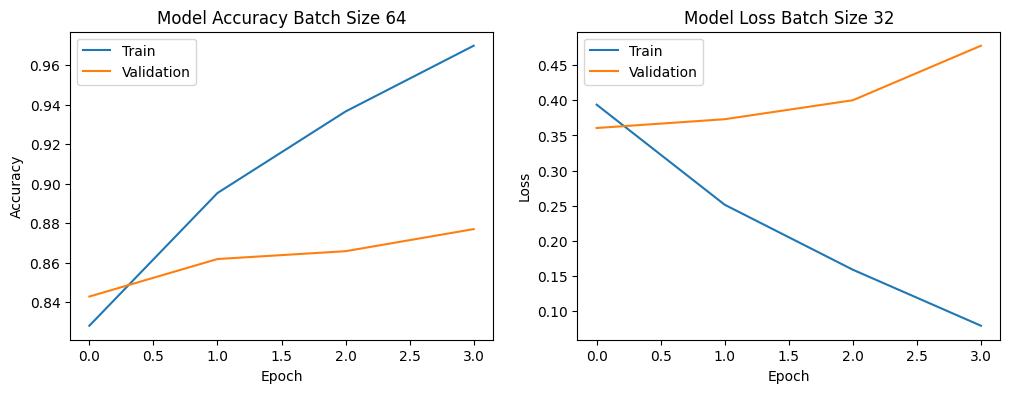

In [22]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Batch Size 64')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Batch Size 32')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

**<h1>VALIDATION</h1>**

In [30]:
y_pred_prob = model.predict(test_tf_dataset).logits
y_pred = np.argmax(y_pred_prob, axis=1)

8790/8790 [==============================] - 165s 19ms/step


In [31]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

In [32]:
conf_matrix = confusion_matrix(y_true, y_pred)

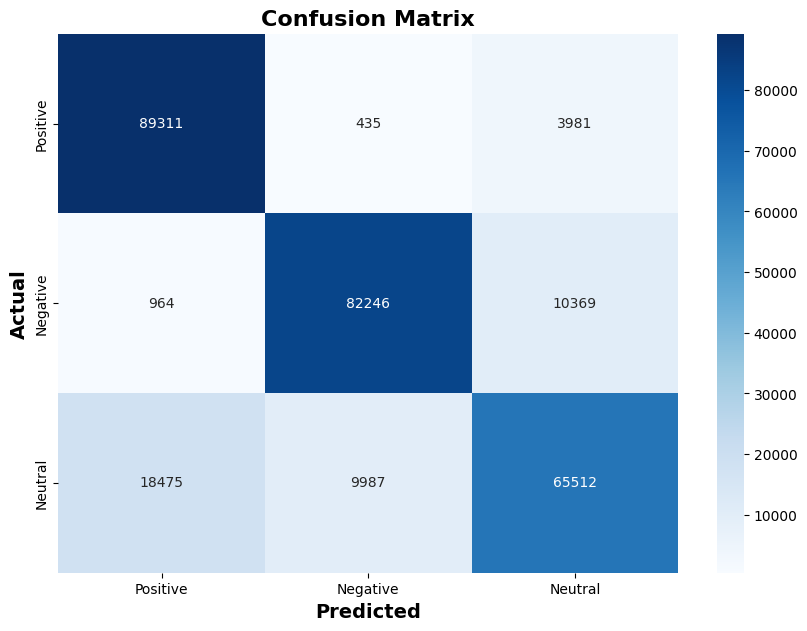

In [33]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [34]:
print(classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.82      0.95      0.88     93727
    Negative       0.89      0.88      0.88     93579
     Neutral       0.82      0.70      0.75     93974

    accuracy                           0.84    281280
   macro avg       0.84      0.84      0.84    281280
weighted avg       0.84      0.84      0.84    281280

